#Training Birds Image Classification

## Download dataset and load libraries

It will first ask for Kaggle API token file, which will be uploaded to colab environment. (Instructions to get this token file are [Here](https://www.kaggle.com/docs/api))

In [1]:
# Based on https://www.kaggle.com/general/74235
from google.colab import files
files.upload() # upload kaggle.json file to colab environment
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
# download the dataset
!kaggle datasets download -d gpiosenka/100-bird-species
!unzip -q 100-bird-species.zip -d dataset
!rm 100-bird-species.zip

Saving kaggle.json to kaggle.json
 99% 1.49G/1.49G [00:22<00:00, 86.5MB/s]
100% 1.49G/1.49G [00:22<00:00, 72.4MB/s]


In [2]:
# fix folder name error
! mv 'dataset/train/BLACK & YELLOW  BROADBILL' 'dataset/train/BLACK & YELLOW BROADBILL'

In [ ]:
# copy fine-tuned model
from google.colab import drive
import shutil
import os
drive.mount('/content/drive')
filename = "first_efficientnet_b3a.pth"
os.mkdir('models')
shutil.copy("/content/drive/MyDrive/Birds_400/"+filename,"models/"+filename)

In [3]:
# make sure we have latest version of fastai
!pip install -q git+https://github.com/fastai/fastai
!pip install timm

     |████████████████████████████████| 55 kB 4.1 MB/s 
     |████████████████████████████████| 431 kB 14.6 MB/s 


In [40]:
import fastai
import timm
print("versions of fastai and timm at the time of running")
print("fastai: ",fastai.__version__)
print("timm: ",timm.__version__)

versions of fastai and timm at the time of running
fastai:  2.5.5
timm:  0.5.4


In [4]:
from fastai.vision.all import *
from fastai.vision.widgets import *
from timm import create_model,list_models
from fastai.vision.learner import _update_first_layer

##A look at dataset

In [5]:
path = Path('dataset/')
Path.BASE_PATH = path
path.ls()

(#9) [Path('birds latin names.csv'),Path('test'),Path('EfficientNetB4-BIRDS-0.99.h5'),Path('train'),Path('images to test'),Path('valid'),Path('class_dict.csv'),Path('my_csv-2-17-2022-1-17-48.csv'),Path('birds.csv')]

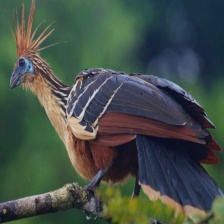

In [6]:
img = (path/'train'/'HOATZIN').ls()[0]
PILImage.create(img)

##Construct DataBlock and DataLoaders

we use random split instead of given train and validation split, because data provider mentioned validation and test set are hand picked as 'best' images.Thus, using a random split would increase model's generalization performance when fine-tuning.

In [7]:
# Resize each image to 150 pixels to speed up training
# Use default data augmentation
birds = DataBlock(blocks=(ImageBlock,CategoryBlock),
                  get_items = partial(get_image_files,folders=['train','valid']),
                  splitter = RandomSplitter(seed=42),
                  get_y = parent_label,
                  item_tfms = Resize(150),
                  batch_tfms = aug_transforms(min_scale=0.75))

In [8]:
dls = birds.dataloaders(path)

In [9]:
# we use the given test set for evaluation after training process
test_dl = dls.test_dl(get_image_files(path/'test'),with_labels=True)

Take a look at some images in dataloaders to make sure everything works

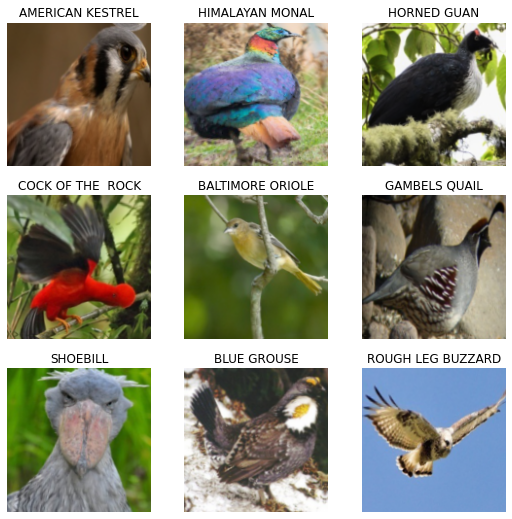

In [10]:
dls.show_batch()

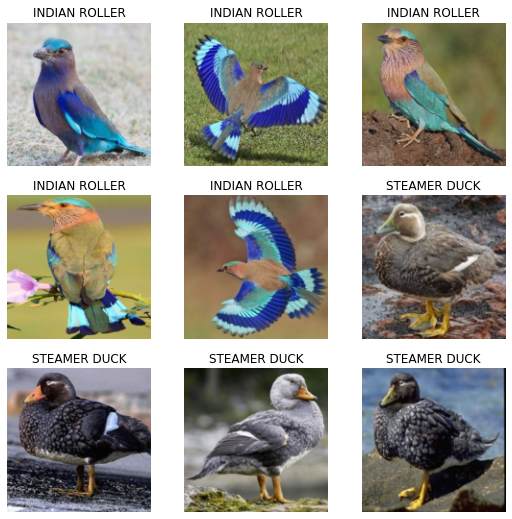

In [28]:
test_dl.show_batch()

##Pre-trained Model
We will use Computer Vision pre-trained models from Ross Wightman's timm Library. Other great models and results are in his [repository](https://github.com/rwightman/pytorch-image-models)

In [12]:
# small change to fastai's create_body function, so we can use pre-trained model from timm library
def create_timm_body(arch:str, pretrained=True, cut=None, n_in=3):
    "Creates a body from any model in the `timm` library."
    model = create_model(arch, pretrained=pretrained, num_classes=0, global_pool='')
    _update_first_layer(model, n_in, pretrained)
    if cut is None:
        ll = list(enumerate(model.children()))
        cut = next(i for i,o in reversed(ll) if has_pool_type(o))
    if isinstance(cut, int): return nn.Sequential(*list(model.children())[:cut])
    elif callable(cut): return cut(model)
    else: raise NamedError("cut must be either integer or function")

In [13]:
body = create_timm_body('efficientnet_b3a', pretrained=True)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/efficientnet_b3_ra2-cf984f9c.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b3_ra2-cf984f9c.pth


In [14]:
nf = num_features_model(body); nf

1536

In [15]:
head = create_head(nf, dls.c,concat_pool=True)

In [16]:
net = nn.Sequential(body,head)

## Learner

In [17]:
learn = Learner(dls, net,splitter=default_split,metrics=accuracy)

We use fastai's convenient learning rate finder, which evaluate loss for a range of learning rates

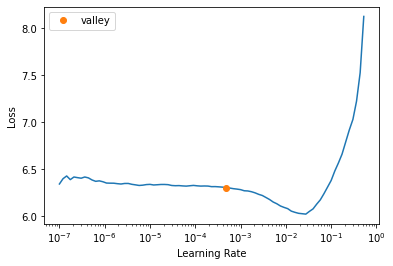

In [18]:
first_lr = learn.lr_find()

First train the head of our neural net, which is the last layer, for our classification task of 400 birds

In [19]:
learn.fit_one_cycle(3,1e-3)

epoch,train_loss,valid_loss,accuracy,time
0,0.955815,0.653505,0.833568,05:06
1,0.443450,0.297158,0.924485,05:07
2,0.187128,0.215655,0.945847,05:06


In [20]:
# Unfreeze neural net so all weights are trainable
learn.unfreeze()

SuggestedLRs(valley=0.0002754228771664202)

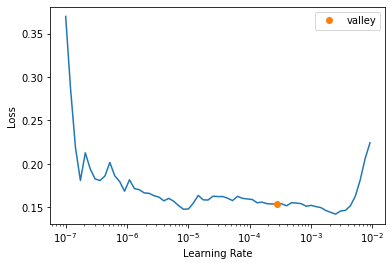

In [21]:
learn.lr_find()

In [22]:
# passing slice to learning rate allows discriminative learning rates
learn.fit_one_cycle(10,slice(1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.139456,0.212242,0.947504,05:07
1,0.139572,0.209642,0.948332,05:07
2,0.113426,0.203008,0.949408,05:07
3,0.117065,0.200288,0.950236,05:07
4,0.109155,0.196807,0.950567,05:07
5,0.099855,0.194876,0.951726,05:07
6,0.091905,0.194294,0.951644,05:08
7,0.079558,0.189990,0.952472,05:07
8,0.082498,0.191999,0.952554,05:07
9,0.079164,0.193507,0.951726,05:07


In [36]:
learn.export('first_efficientnet_b3a.pkl')

In [23]:
learn.save('first_efficientnet_b3a')

Path('models/first_efficientnet_b3a.pth')

In [ ]:
learn = learn.load('first_efficientnet_b3a')

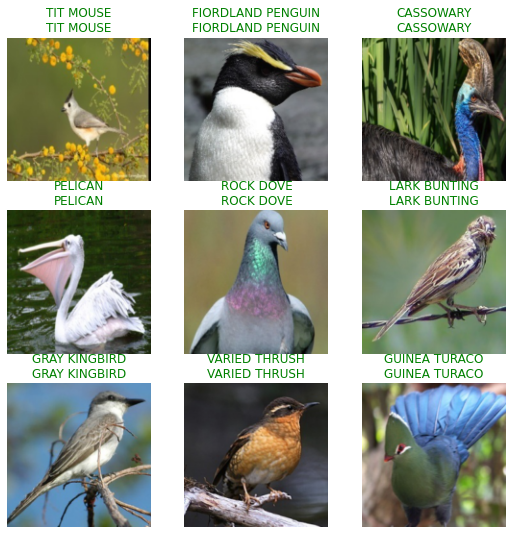

In [24]:
# green means correct prediction and red otherwise
learn.show_results()

A look at top losses from evaluating validation set. 

Wrong predictions with high confident would rank higher in top losses.

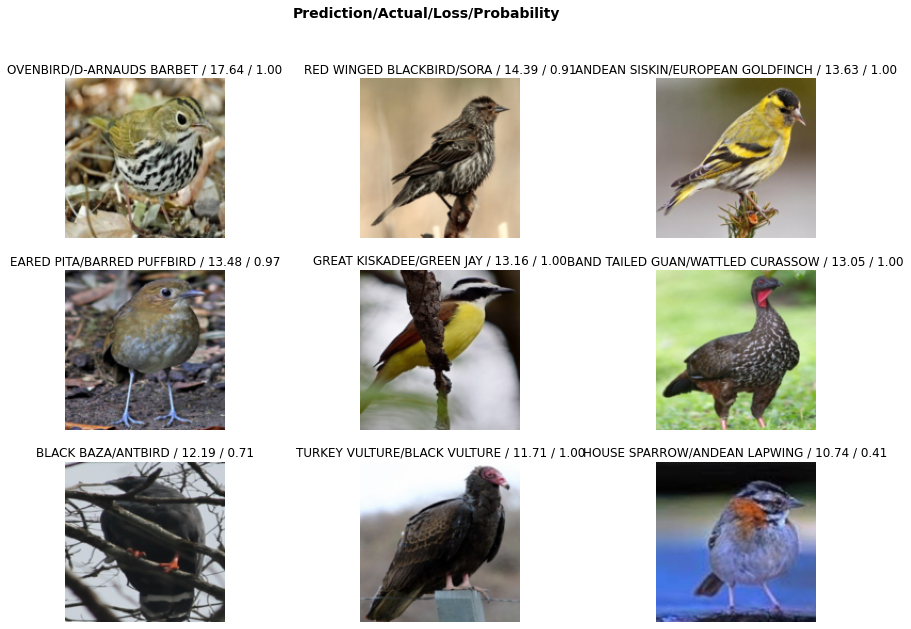

In [25]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_top_losses(9, figsize=(15,10))

Evaluation of the unseen test set gives 99.4% accuracy

In [29]:
# outputs represent loss and accuracy
learn.validate(dl=test_dl)

(#2) [0.03166836500167847,0.9940000176429749]

Let's try a random image of Hoatzin from Google search

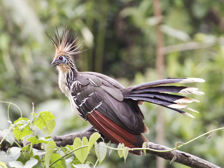

In [31]:
Hoatzin = PILImage.create('Hoatzin.jpg')
Hoatzin.to_thumb(224)

In [33]:
learn.predict('Hoatzin.jpg')[0]

'HOATZIN'

Works great! We can use the saved model for deployment.